In [8]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils


In [9]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [10]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [11]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            # print(state)
            # print(len(state))
            State = torch.tensor([state], dtype=torch.float).to(self.device)
            # print(State)
            action = self.q_net(State).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones
                                                                )  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [12]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
# device = torch.device("mps") if torch.backends.mps.is_available() and torch.backends.mps.is_built() else torch.device(
#     "cpu")
print(device)
env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % (i + 1)) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()[0]
            done = False
            cnt = 1
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, *_ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
                if cnt == 200 :
                    done = True
                cnt += 1
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

cpu


Iteration 9: 100%|█| 50/50 [00:03<00:00, 12.71it/s, episode=450, return=200.000]
Iteration 10: 100%|█| 50/50 [00:03<00:00, 12.74it/s, episode=500, return=200.000


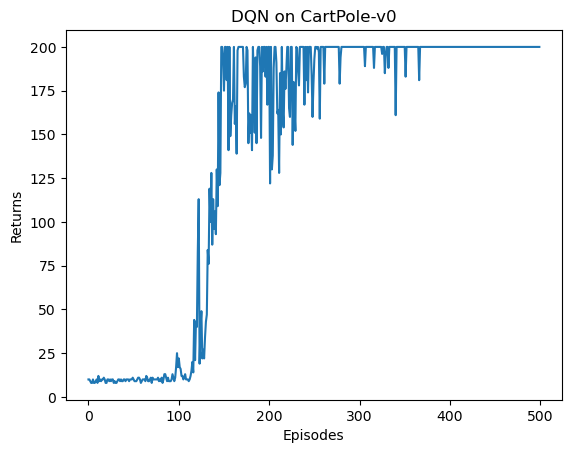

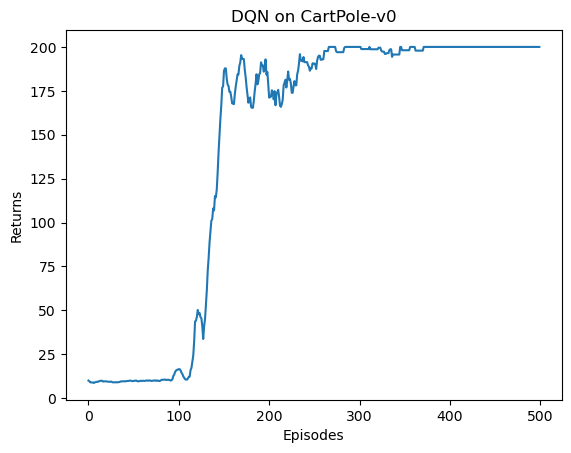

In [13]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [14]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

state = env.reset()[0]
action = agent.take_action(state)
env.step(action)

(array([-0.02325628, -0.15274957,  0.02005385,  0.31532943], dtype=float32),
 1.0,
 False,
 False,
 {})